# Policy Robustness and Policy Selection

We analyze the robustness of policy candidates identified through directed search, further constrained to meet the transport company's acceptability criteria. This process helps us investigate robustness trade-offs and select the most robust policies.

#### Robustness Metrics

1. **Signal to Noise Ratio (SNR)**: This metric assesses expected performance across various scenarios. We target low values, aligning with our goal to minimize all outcomes. It is calculated by multiplying the mean and standard deviation of the outcome values across all scenarios.

2. **Maximum Regret**: This metric evaluates the regret of a policy, defined as the difference between the policy's performance in a specific scenario and the best possible performance in that scenario. Maximum regret is determined for each policy and outcome across all scenarios.

SNR evaluates the overall performance of our candidate solutions, while maximum regret focuses on worst-case scenarios. These metrics, along with qualitative and operational factors, guide the selection of our final recommended policies.

-------------------
## 0. Imports and Setup

In [1]:
from ema_workbench.em_framework.evaluators import perform_experiments

from ema_workbench import (
    Model,
    Policy,
    MultiprocessingEvaluator,
    SequentialEvaluator,
    ScalarOutcome,
    IntegerParameter,
    optimize,
    Scenario,
)

from ema_workbench import save_results, load_results

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

from ema_workbench import (
    ScalarOutcome,
    load_results
)
from ema_workbench.analysis import parcoords
from ema_workbench.util import ema_logging

from problem_formulation import get_model_for_problem_formulation

In [2]:
dike_model, planning_steps = get_model_for_problem_formulation('Urban Dikes')

# 50 policies from file
policies_df = pd.read_csv('./output/policies__constraints_filtered__diverse_set_50.csv',
                        index_col='Policy Name')
policies_df = policies_df[[L.name for L in dike_model.levers]]

policies = []
for name, policy in policies_df.iterrows():
    policies.append(Policy(str(name), **policy.to_dict()))

# 1000 scenarios: limited by compute time x 50 policies, but a
# large number is not needed, as the goal is not scenario search
n_scenarios = 1000

In [3]:
with MultiprocessingEvaluator(dike_model) as evaluator:
    results = evaluator.perform_experiments(n_scenarios,policies)

100%|████████████████████████████████████| 50000/50000 [38:41<00:00, 21.54it/s]


In [4]:
# save the results
experiments, outcomes = results

In [5]:
# export results to have a reproducible results
save_results((experiments, outcomes), './output/robustness_results_policies.tar.gz')

As input to this analysis we take results of performing experiments for the 50 policies coming from directed search across 1000 scenarios which were conducted with *run_robustness_experiments.py* script. 

In [6]:
robustness_results = load_results('./output/robustness_results_policies.tar.gz')
experiments, outcomes = robustness_results

Next, we separate the experiment results based on the four scenarios used in the directed search and the specific policy they were initially generated for, allowing us to group the results by scenario.

In [7]:
# Add a column informing of original scenario
experiments['Original Scenario'] = ''
for idx, row in experiments.iterrows():
    experiments.at[idx, 'Original Scenario'] = row.policy.split('_')[0][1:]

In [8]:
# Create two dictionaries separating entries by scenarios
experiments_by_scenario = {}
outcomes_by_scenario = {}
scenarios = np.unique(experiments['Original Scenario'])

for scenario in scenarios:
    experiments_by_scenario[scenario] = experiments[experiments['Original Scenario'] == scenario]

    indices = list(experiments_by_scenario[scenario].index)

    outcomes_by_scenario[scenario] = {}
    for key, array in outcomes.items():
        outcomes_by_scenario[scenario][key] = []

        for i in indices:
            outcomes_by_scenario[scenario][key].append(array[i])

----------

## 1. Signal to Noise Ratio (SNR)

### Calculations

In [9]:
# Function to calculate SNR metric
def snr(data, direction):
    mean = np.mean(data)
    std = np.std(data)

    if direction==ScalarOutcome.MINIMIZE:
        return mean*std
    else:
        return mean/std

In [10]:
# Define variables relevant for correct handling of policy filtering
model, steps = get_model_for_problem_formulation('Urban Dikes')
outcomes_of_interest = [
                        'A3ExpectedAnnualDamage', 'A3ExpectedNumberofDeaths',
                        'A5ExpectedAnnualDamage', 'A5ExpectedNumberofDeaths',
                        'Total_Dike_Investment']

In [11]:
# Calculate SNR scores per policy per outcome and write it to a dictionary organized by scenario
snr_scores = {}
for scenario in scenarios:
    experiment_snr_scores = {}
    for policy in experiments_by_scenario[scenario]['policy']:
        scores = {}
        
        logical = experiments['policy']==policy
        
        for outcome in model.outcomes:
            value  = outcomes[outcome.name][logical]
            sn_ratio = snr(value, outcome.kind)
            scores[outcome.name] = sn_ratio
        experiment_snr_scores[policy] = scores
    df = pd.DataFrame.from_dict(experiment_snr_scores).T
    snr_scores[scenario] = df

In [12]:
# Ensure '248' is in scenarios list
print('248' in scenarios)

# Calculate SNR scores per policy per outcome and write it to a dictionary organized by scenario
snr_scores = {}
for scenario in scenarios:
    experiment_snr_scores = {}
    for policy in experiments_by_scenario[scenario]['policy']:
        scores = {}

        logical = experiments['policy'] == policy

        for outcome in model.outcomes:
            value = outcomes[outcome.name][logical]
            sn_ratio = snr(value, outcome.kind)
            scores[outcome.name] = sn_ratio
        experiment_snr_scores[policy] = scores

    df = pd.DataFrame.from_dict(experiment_snr_scores).T
    snr_scores[scenario] = df

# Print the keys of snr_scores to verify scenarios processed
print("Scenarios in snr_scores:", snr_scores.keys())

# Print summary for each scenario
for scenario, df in snr_scores.items():
    print(f"\nScenario: {scenario}")
    print(f"Policies: {df.index.tolist()}")
    print(f"Outcomes: {df.columns.tolist()}")
    print(f"SNR Scores Summary:\n{df.describe()}")




True
Scenarios in snr_scores: dict_keys(['248', '541', '632', '982'])

Scenario: 248
Policies: ['s248_p195', 's248_p505', 's248_p28', 's248_p396', 's248_p693', 's248_p63', 's248_p719', 's248_p543', 's248_p184', 's248_p57', 's248_p296', 's248_p711', 's248_p903', 's248_p684', 's248_p461', 's248_p290', 's248_p74', 's248_p579', 's248_p610']
Outcomes: ['A3ExpectedAnnualDamage', 'A3ExpectedNumberofDeaths', 'A3DikeInvestmentCosts', 'A5ExpectedAnnualDamage', 'A5ExpectedNumberofDeaths', 'A5DikeInvestmentCosts', 'Total_Dike_Investment', 'Total_Expected_Annual_Damage', 'Total_Expected_Number_of_Deaths']
SNR Scores Summary:
       A3ExpectedAnnualDamage  A3ExpectedNumberofDeaths  \
count            1.900000e+01              1.900000e+01   
mean             6.472484e+15              8.961001e-03   
std              1.016205e+16              1.846840e-02   
min              0.000000e+00              0.000000e+00   
25%              2.635429e+12              1.464694e-07   
50%              8.759096e

In [13]:
snr_scores['982'].head()

,A3ExpectedAnnualDamage,A3ExpectedNumberofDeaths,A3DikeInvestmentCosts,A5ExpectedAnnualDamage,A5ExpectedNumberofDeaths,A5DikeInvestmentCosts,Total_Dike_Investment,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
s982_p738,3.734494e+11,1.626439e-06,14840.299176,6.150704e+16,0.050252,0.000000,52292.627508,8.173709e+16,0.059951
s982_p889,8.727308e+11,3.088904e-06,72.143827,3.743792e+12,0.000003,130.549974,0.000000,7.166833e+12,0.000010
s982_p117,6.449676e+09,4.784155e-09,1149.814816,2.533431e+14,0.000029,5.581996,80563.604433,1.113018e+15,0.000122
s982_p435,3.143367e+09,2.424034e-09,0.000000,4.547722e+15,0.000483,14.402445,0.000000,5.208602e+15,0.000522
s982_p510,0.000000e+00,0.000000e+00,91758.723242,3.226315e+16,0.027087,0.000000,141685.230516,3.253760e+16,0.027266


The SNR scores for the Total Expected Number of Deaths are close to or equal to zero in many instances. Upon investigation, we found that this is due to the very low (or zero) standard deviation values of the Total Expected Number of Deaths.

### Visualisations

First we determine the limits of the line plots, such that they are kept contant across scenarios.

In [14]:
# Ensure all outcomes_of_interest exist in the concatenated snr_scores DataFrame
concatenated_snr_scores = pd.concat(snr_scores.values())
existing_outcomes = [outcome for outcome in outcomes_of_interest if outcome in concatenated_snr_scores.columns]

if len(existing_outcomes) != len(outcomes_of_interest):
    print(f"Missing outcomes: {[outcome for outcome in outcomes_of_interest if outcome not in existing_outcomes]}")

# Determine min and max values for plotting
limits = parcoords.get_limits(snr_scores[scenarios[0]])
limits.loc[0, existing_outcomes] = 0

for outcome in existing_outcomes:
    limits.loc[1, outcome] = concatenated_snr_scores[outcome].max()

print(limits)

   A3ExpectedAnnualDamage  A3ExpectedNumberofDeaths  A3DikeInvestmentCosts  \
0            0.000000e+00                  0.000000               0.000000   
1            3.671039e+16                  0.099628           12436.047904   

   A5ExpectedAnnualDamage  A5ExpectedNumberofDeaths  A5DikeInvestmentCosts  \
0            0.000000e+00                  0.000000               0.000000   
1            6.150704e+16                  0.050252           12778.525899   

   Total_Dike_Investment  Total_Expected_Annual_Damage  \
0           0.000000e+00                  6.822419e+13   
1           3.782636e+06                  3.763204e+17   

   Total_Expected_Number_of_Deaths  
0                     8.918288e-07  
1                     1.185458e-01  


Next, we plot all candidate policies by SNR robustness scores, color-grouped by origin scenario.

In [15]:
original_scenarios = experiments['Original Scenario'].unique().tolist()
original_scenarios.sort()

C:\Users\Hidayahtullah Abdi R\AppData\Local\Programs\Python\Python312\Lib\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\Hidayahtullah Abdi R\AppData\Local\Programs\Python\Python312\Lib\site-packages\ema_workbench\analysis\parcoords.py:281: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


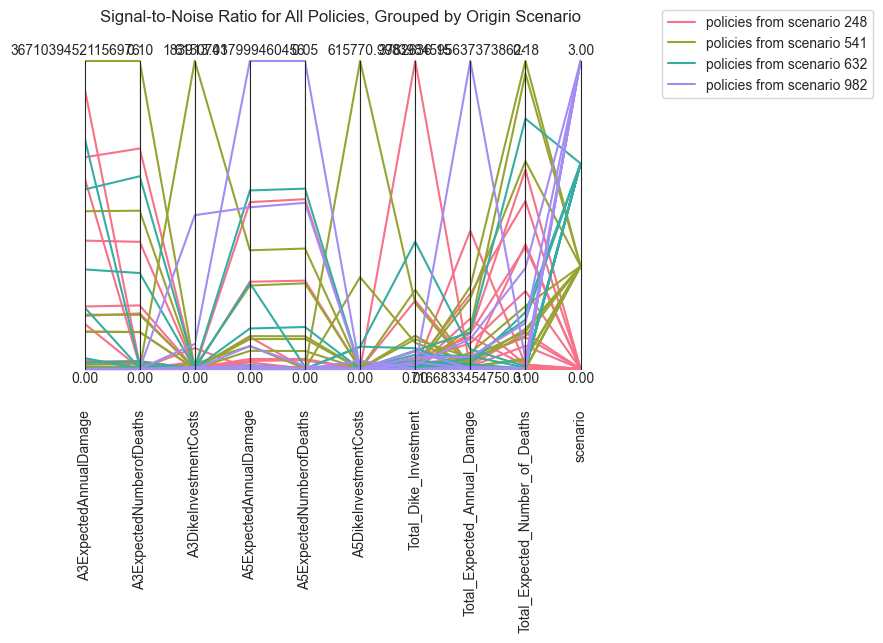

In [41]:
colors = sns.color_palette("husl", len(scenarios))
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for count, scenario in enumerate(scenarios):

    data = snr_scores[scenario]
    paraxes.plot(data, color=colors[count], label='policies from scenario ' + original_scenarios[count])
        
    plt.title(f'Signal-to-Noise Ratio for All Policies, Grouped by Origin Scenario', loc='right')
    plt.savefig('img/snr__all_grouped_pairplot.png')
    
paraxes.legend()

The diagram is hard to read due to the overlapping lines. 

Next, we plot SNR of candidate policies individually per origin scenario, for easier visual inspection and to compare differences between the policies based on their origin scenario.

C:\Users\Hidayahtullah Abdi R\AppData\Local\Programs\Python\Python312\Lib\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\Hidayahtullah Abdi R\AppData\Local\Programs\Python\Python312\Lib\site-packages\ema_workbench\analysis\parcoords.py:281: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


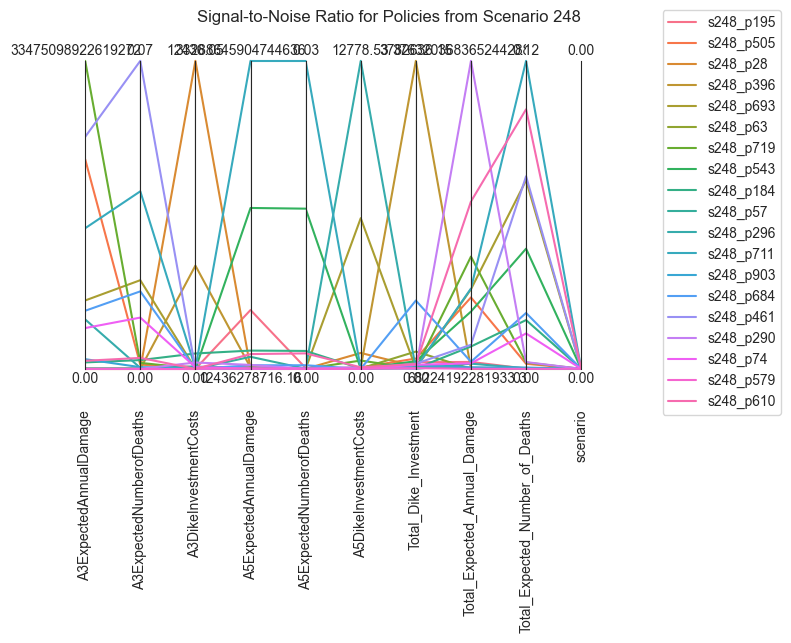

C:\Users\Hidayahtullah Abdi R\AppData\Local\Programs\Python\Python312\Lib\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\Hidayahtullah Abdi R\AppData\Local\Programs\Python\Python312\Lib\site-packages\ema_workbench\analysis\parcoords.py:281: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


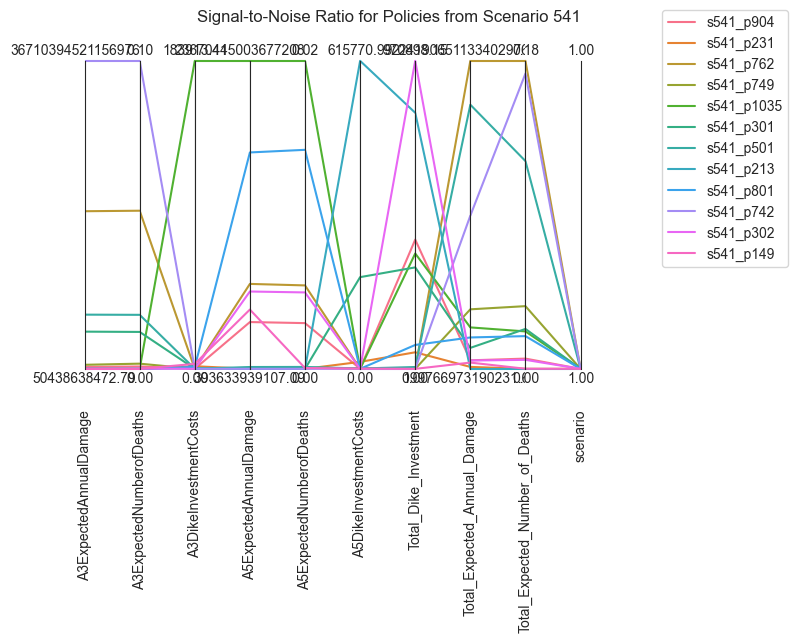

C:\Users\Hidayahtullah Abdi R\AppData\Local\Programs\Python\Python312\Lib\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\Hidayahtullah Abdi R\AppData\Local\Programs\Python\Python312\Lib\site-packages\ema_workbench\analysis\parcoords.py:281: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


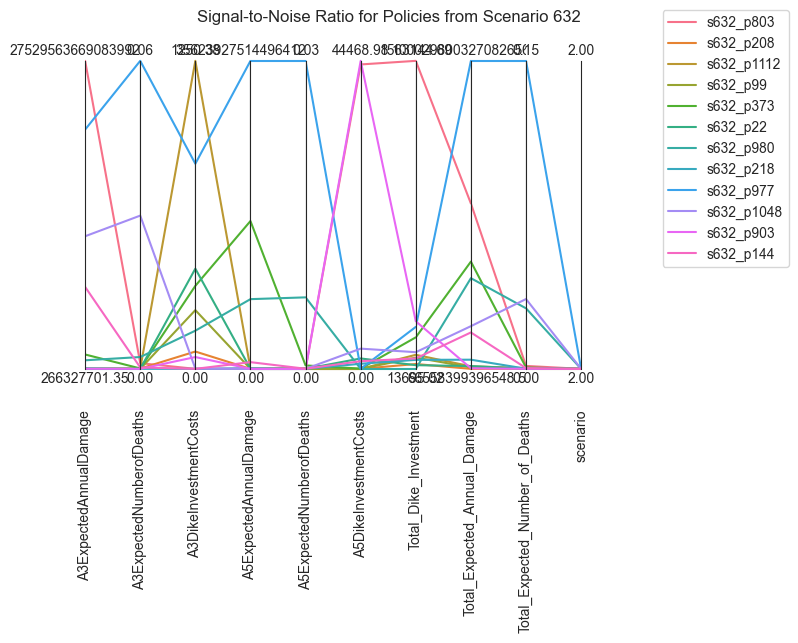

C:\Users\Hidayahtullah Abdi R\AppData\Local\Programs\Python\Python312\Lib\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\Hidayahtullah Abdi R\AppData\Local\Programs\Python\Python312\Lib\site-packages\ema_workbench\analysis\parcoords.py:281: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


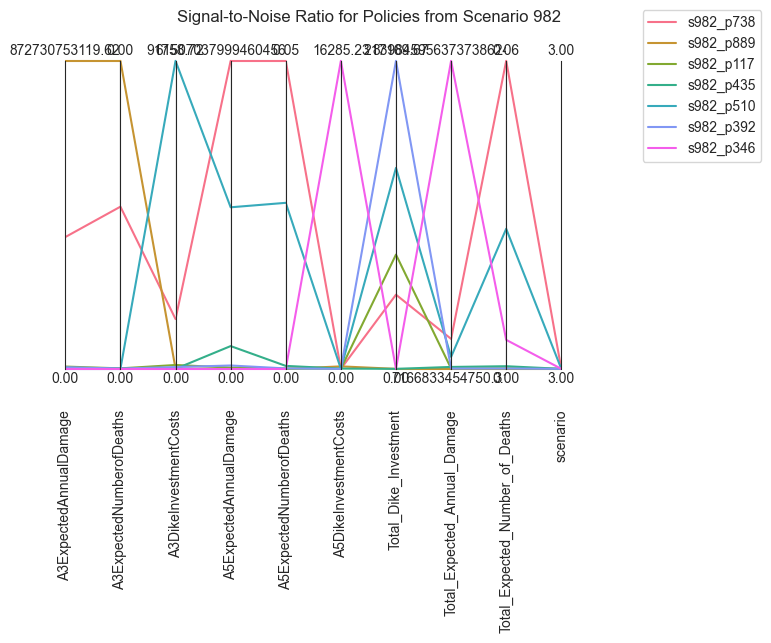

In [48]:
import matplotlib.pyplot as plt
import seaborn as sns
from ema_workbench.analysis import parcoords
import pandas as pd

for scenario in scenarios:
    data = snr_scores[scenario]

    # Calculate limits dynamically based on the range of SNR scores for the current scenario
    limits = pd.concat([data.min(), data.max()], axis=1).T

    colors = sns.color_palette("husl", data.shape[0])
    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])

    paraxes.legend()
    plt.title(f'Signal-to-Noise Ratio for Policies from Scenario {scenario}', loc='right')
    plt.savefig(f'img/snr__all_{scenario}_pairplot.png')
    plt.show()

    # Export the resulting data to a CSV file
    data.to_csv(f'output/snr_scores_scenario_{scenario}.csv', index=True)

Above graphs allow to see how many policies there are per scenario, and compare them within scenario as well as between scenarios.

### Helper dataframes

In this section we prepare:
1. a single dataframe for robustness scores for easier further processing, initially filled with SNR scores (*all_data*)
2. a dataframe mapping policy to the non-zero levers used (*all_levers*)

In [18]:
# Create a helper df containing all policies and the policy levers they activate
list(experiments.columns)
lever_start = experiments.columns.get_loc('EWS_DaysToThreat')
lever_end = experiments.columns.get_loc('A.5_DikeIncrease 2')
policy_levers = experiments.iloc[: , lever_start:lever_end]
policy_levers['policy'] = experiments['policy']
policy_levers.head(20)

,EWS_DaysToThreat,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,policy
0,3,5,5,3,4,10,1,10,3,10,1,1,3,1,4,s248_p195
1,3,5,5,3,4,10,1,10,3,10,1,1,3,1,4,s248_p195
2,3,5,5,3,4,10,1,10,3,10,1,1,3,1,4,s248_p195
3,3,5,5,3,4,10,1,10,3,10,1,1,3,1,4,s248_p195
4,3,5,5,3,4,10,1,10,3,10,1,1,3,1,4,s248_p195
5,3,5,5,3,4,10,1,10,3,10,1,1,3,1,4,s248_p195
6,3,5,5,3,4,10,1,10,3,10,1,1,3,1,4,s248_p195
7,3,5,5,3,4,10,1,10,3,10,1,1,3,1,4,s248_p195
8,3,5,5,3,4,10,1,10,3,10,1,1,3,1,4,s248_p195
9,3,5,5,3,4,10,1,10,3,10,1,1,3,1,4,s248_p195


In [19]:
# Create a dataframe storing SNR results per policy
all_data = pd.DataFrame()

for count, scenario in enumerate(scenarios):
    data = snr_scores[scenario]
    data['scenario'] = count
    all_data = pd.concat([all_data, data])

# Set the name for the index
all_data = all_data.rename_axis('policy')

all_data.head(3)


,A3ExpectedAnnualDamage,A3ExpectedNumberofDeaths,A3DikeInvestmentCosts,A5ExpectedAnnualDamage,A5ExpectedNumberofDeaths,A5DikeInvestmentCosts,Total_Dike_Investment,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths,scenario
policy,,,,,,,,,,
s248_p195,0.000000e+00,0.000000e+00,0.000000,6.358999e+15,7.713263e-05,6.055404,81621.012136,8.510619e+15,0.000091,0
s248_p505,2.277470e+16,9.635233e-04,71.913952,1.894166e+14,2.444001e-06,60.501316,126743.941540,8.730079e+16,0.001950,0
s248_p28,3.992579e+09,3.061057e-10,12436.047904,2.166917e+13,2.596638e-07,659.333084,28308.477942,2.419862e+14,0.000002,0


In [20]:
# Create a helper df
candidate_policies = all_data.reset_index()
candidate_policies = candidate_policies.iloc[:,0]
candidate_policies = candidate_policies.tolist()

In [21]:
# Create sorted df, with all levers that are used at least once as columns, and all policies as rows
all_levers = pd.DataFrame()

for policy in candidate_policies:
    df = policy_levers.loc[policy_levers['policy'] == policy]
    df = df.iloc[[0]]
    nonzero_columns = (df != 0).all()
    df = df.loc[:, nonzero_columns]
    all_levers = pd.concat([all_levers, df])

all_levers = all_levers.reindex(sorted(all_levers.columns), axis=1)
all_levers.set_index('policy', inplace=True)
all_levers.head()

,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,EWS_DaysToThreat
policy,,,,,,,,,,,,,,,
s248_p195,5.0,5.0,3.0,4.0,10.0,1.0,10.0,3.0,10.0,1.0,1.0,3.0,1.0,4.0,3.0
s248_p505,7.0,10.0,7.0,NaN,NaN,1.0,1.0,7.0,2.0,9.0,NaN,5.0,4.0,3.0,3.0
s248_p28,4.0,3.0,2.0,4.0,5.0,2.0,7.0,3.0,10.0,9.0,10.0,NaN,4.0,3.0,4.0
s248_p396,7.0,7.0,8.0,10.0,9.0,10.0,5.0,8.0,7.0,NaN,2.0,NaN,2.0,3.0,3.0
s248_p693,1.0,NaN,6.0,3.0,1.0,NaN,2.0,1.0,2.0,3.0,2.0,2.0,10.0,3.0,NaN


After inspecting the visualizations above, the following conclusions were drawn :

*Note that we are only looking within origin scenarios to easily (and visually) identify dominance within a smaller selection of the candidate policy set.*

In terms of SNR:

Levers based on Deaths 
- in scenario 248, policy 195 & 693 are selected 
- in scenario 541, policy 213 & 149 is selected
- in scenario 632, policy 22 & 208 is selected
- in scenario 982, policy 346 & 510 is selected

Levers based on Damage 
- in scenario 248, policy 195 & 693 is selected
- in scenario 541, policy 149 & 301 is selected
- in scenario 632, policy 22 & 208 is selected
- in scenario 982, policy 346 & 510 is selected

#### Comment on the remaining policies

Here, we prepare a dataframe of remaining policies and print it to inspect the levers visually.

In [22]:
# Create a list of all remaining policies after initial filtering
remaining_policies = all_data.reset_index()
remaining_policies = remaining_policies.iloc[:,0]
remaining_policies = remaining_policies.tolist()

In [23]:
# Create a df with all columns with non-zero values and rows as policies
remaining_levers = pd.DataFrame()

for policy in remaining_policies:
    df = policy_levers.loc[policy_levers['policy'] == policy]
    df = df.iloc[[0]]
    nonzero_columns = (df != 0).all()
    df = df.loc[:, nonzero_columns]
    remaining_levers = pd.concat([remaining_levers, df])

remaining_levers = remaining_levers.reindex(sorted(remaining_levers.columns), axis=1)
remaining_levers.set_index('policy', inplace=True)

In [24]:
remaining_levers

,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,EWS_DaysToThreat
policy,,,,,,,,,,,,,,,
s248_p195,5.0,5.0,3.0,4.0,10.0,1.0,10.0,3.0,10.0,1.0,1.0,3.0,1.0,4.0,3.0
s248_p505,7.0,10.0,7.0,NaN,NaN,1.0,1.0,7.0,2.0,9.0,NaN,5.0,4.0,3.0,3.0
s248_p28,4.0,3.0,2.0,4.0,5.0,2.0,7.0,3.0,10.0,9.0,10.0,NaN,4.0,3.0,4.0
s248_p396,7.0,7.0,8.0,10.0,9.0,10.0,5.0,8.0,7.0,NaN,2.0,NaN,2.0,3.0,3.0
s248_p693,1.0,NaN,6.0,3.0,1.0,NaN,2.0,1.0,2.0,3.0,2.0,2.0,10.0,3.0,NaN
s248_p63,5.0,NaN,10.0,6.0,5.0,9.0,5.0,3.0,6.0,7.0,2.0,7.0,2.0,4.0,3.0
s248_p719,NaN,4.0,1.0,NaN,5.0,3.0,NaN,5.0,NaN,4.0,3.0,7.0,7.0,1.0,3.0
s248_p543,1.0,10.0,9.0,NaN,3.0,2.0,7.0,4.0,1.0,8.0,6.0,7.0,NaN,2.0,NaN
s248_p184,NaN,6.0,1.0,NaN,7.0,2.0,2.0,8.0,4.0,4.0,2.0,4.0,1.0,3.0,NaN


In the DataFrame above, the policy levers that were activated to create each of the remaining 50 candidate policies can be seen. Due to a smaller number of policies we can already inspect what levers they include.

---------------------

## 2. Maximum Regret


In [25]:
# Function to calculate regret
def calculate_regret(data, best):
    return np.abs(best-data)

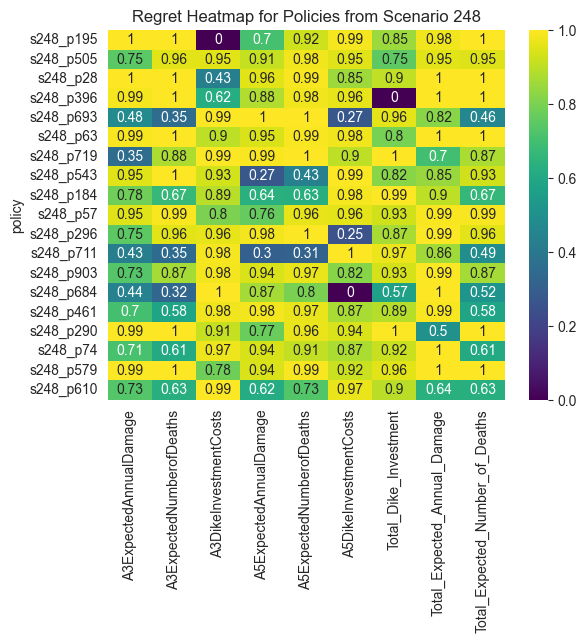

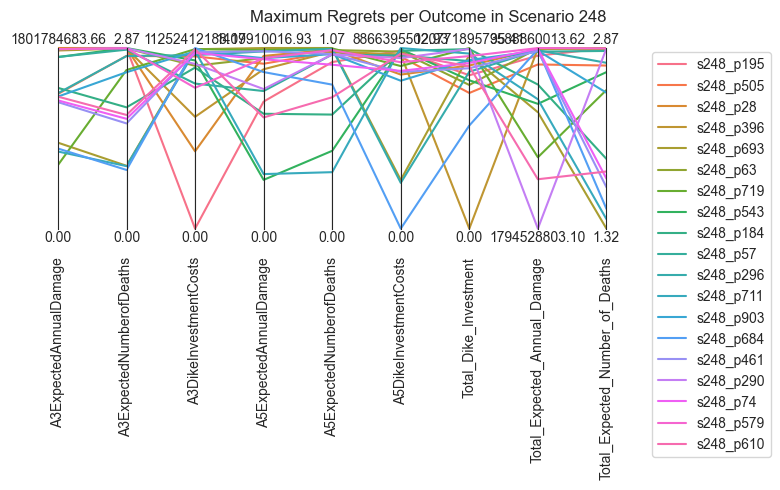

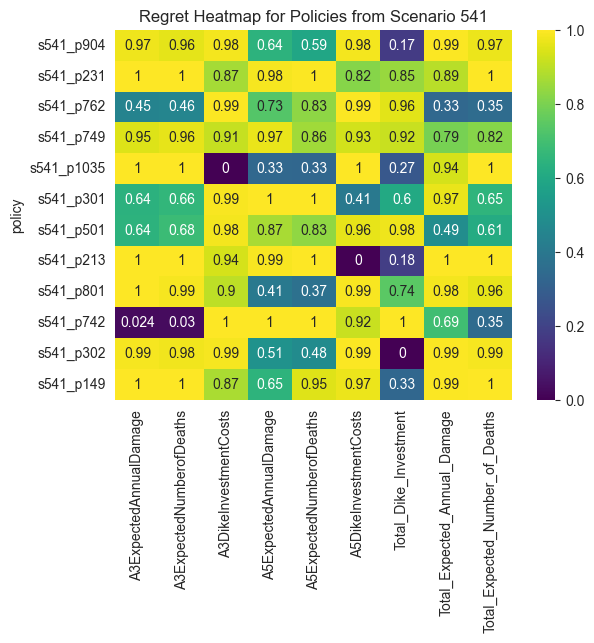

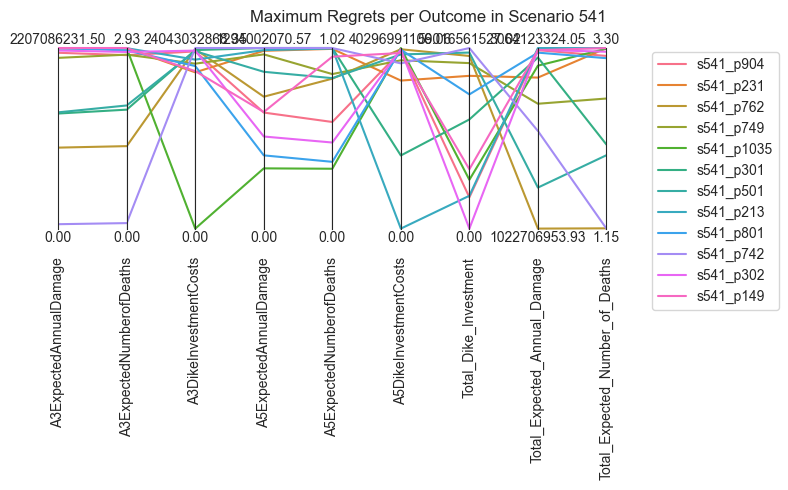

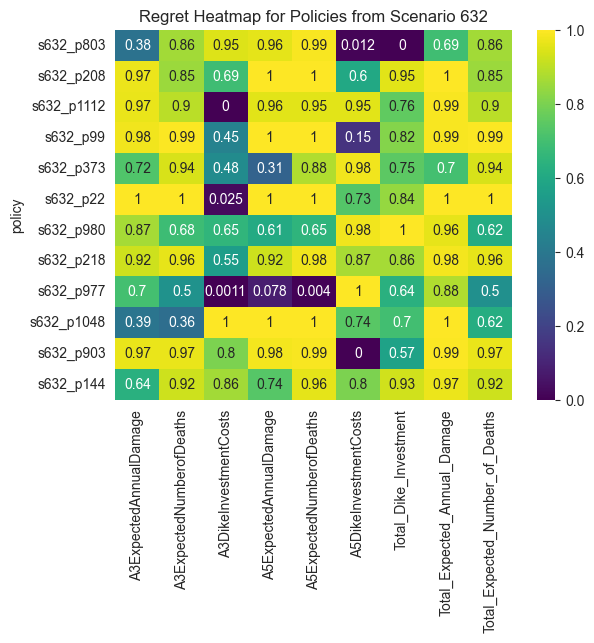

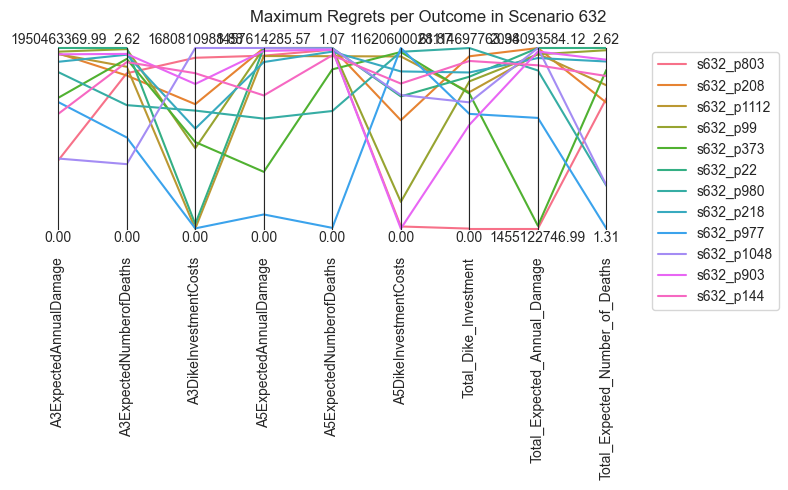

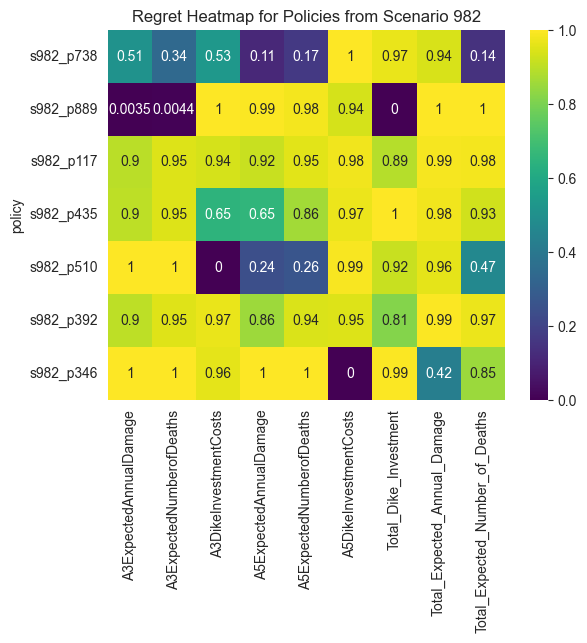

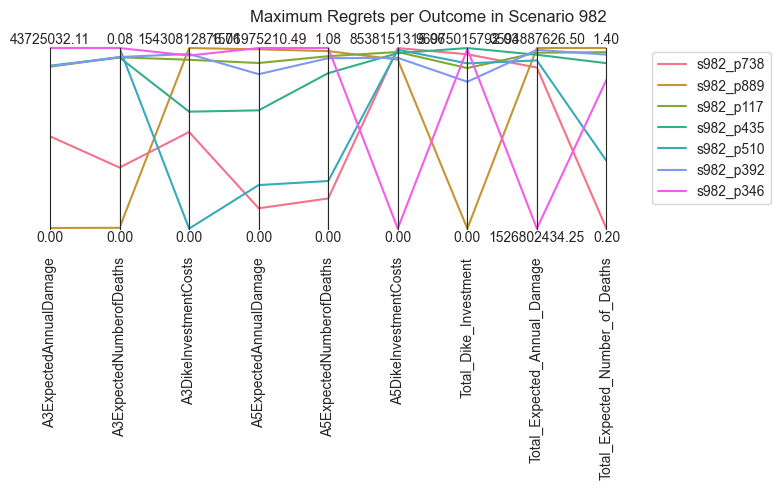

In [26]:
# Generate of a dataframe and plots of maximum regret metric per each scenario separately
for scenario in scenarios:
    
    all_regrets = {}
    max_regret = {}
    
    for outcome in model.outcomes:
        experiments_df = experiments_by_scenario[scenario]
        outcomes_dict = outcomes_by_scenario[scenario]
        # Create a DataFrame with all the relevent information
        # i.e., policy, scenario_id, and scores
        data = pd.DataFrame({
            outcome.name : outcomes_dict[outcome.name], 
            "policy" : experiments_df['policy'],
            "robustness_scenario" : experiments_df['scenario'],
        })
        
        # Filter out rows that are not for policies kept according to signal to noise ratio. 
        data = data[data['policy'].isin(remaining_policies)]

        # Reorient the data by indexing with policy and scenario id
        data = data.pivot(index='robustness_scenario', columns='policy')

        data.columns = data.columns.get_level_values(1)
        outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
        
        all_regrets[outcome.name] = outcome_regret
        max_regret[outcome.name] = outcome_regret.max()

    # Plot regret heatmap
    max_regret = pd.DataFrame(max_regret)
    sns.heatmap(max_regret/max_regret.max(), cmap='viridis', annot=True)
    plt.title(f'Regret Heatmap for Policies from Scenario {scenario}')
    plt.savefig('img/regret__top50_' + scenario + '_heatmap.png')
    plt.show()

    # Plot regret pairplot
    data = max_regret

    limits = parcoords.get_limits(data)
    limits.loc[0, outcomes_of_interest] = 0

    paraxes = parcoords.ParallelAxes(limits, fontsize=10)

    for i, (index, row) in enumerate(data.iterrows()):
        colors = sns.color_palette("husl", data.shape[0])
        paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    paraxes.legend()
    plt.title(f'Maximum Regrets per Outcome in Scenario {scenario}', loc='right')
    plt.savefig('img/regret__top50_' + scenario + '_pairplot.png')
        
    plt.show()

After inspecting the visualizations above, the following conclusions were drawn :

*Note that we are only looking within origin scenarios to easily (and visually) identify dominance within a smaller selection of the candidate policy set.*

In terms of Max regret:

Levers based on Deaths
- in scenario 248, policy 684 & 711 are selected 
- in scenario 541, policy 742 & 1035 is selected
- in scenario 632, policy 1048 & 977 is selected
- in scenario 982, policy 889 & 738 is selected

Levers based on Damage
- in scenario 248, policy 719 & 543 are selected
- in scenario 541, policy 742 & 1035 is selected
- in scenario 632, policy 803 & 977 is selected
- in scenario 982, policy 889 & 738 is selected


## 3. Final analysis and selection

#### 3.1 Analytical filtering
Combining aforementioned insights into SNR and Max Regret robustness and levers diversity of policies, we **keep following policies for further analysis**:
in scenario 248: 195*, 693*, 684, 711, 719, 543
in scenario 541: 149*, 213, 301, 742*, 1035*
in scenario 632: 22*, 208*, 1048, 977*, 803
in scenario 982: 346*, 510*, 889*, 738*

* shows more than one occurrence

In [61]:
# Define the keep_list with specified policies
keep_list = [
    's248_p195', 's248_p693', 's248_p684', 's248_p711', 's248_p719', 's248_p543',
    's541_p149', 's541_p213', 's541_p301', 's541_p742', 's541_p1035',
    's632_p22', 's632_p208', 's632_p1048', 's632_p977', 's632_p803',
    's982_p346', 's982_p510', 's982_p889', 's982_p738'
]

# Filter the df of policies to keep only those in the keep_list
all_data = all_data.loc[keep_list]

remaining_policies = all_data.reset_index()
remaining_policies = remaining_policies.iloc[:, 0]
remaining_policies = remaining_policies.tolist()

remaining_levers = pd.DataFrame()

for policy in remaining_policies:
    df = policy_levers.loc[policy_levers['policy'] == policy]
    df = df.iloc[[0]]
    nonzero_columns = (df != 0).all()
    df = df.loc[:, nonzero_columns]
    remaining_levers = pd.concat([remaining_levers, df])

remaining_levers = remaining_levers.reindex(sorted(remaining_levers.columns), axis=1)
remaining_levers.set_index('policy', inplace=True)

Next we plot SNR and Maximum Regret, which we recalculate taking into account only remaining policies. This choice is a limitaion.

#### 3.2 SNR plotting

In [62]:
# Determine min and max values for plotting
limits = parcoords.get_limits(all_data)
limits.loc[0, outcomes_of_interest]  = 0

for outcome in outcomes_of_interest:
    
    limits.loc[1, outcome] = all_data[outcome].max()
limits = limits.drop(columns=['scenario'])

In [63]:
# Sort rows to match the order of Max Regret
all_data = all_data.sort_index()

C:\Users\Hidayahtullah Abdi R\AppData\Local\Programs\Python\Python312\Lib\site-packages\ema_workbench\analysis\parcoords.py:220: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)
C:\Users\Hidayahtullah Abdi R\AppData\Local\Programs\Python\Python312\Lib\site-packages\ema_workbench\analysis\parcoords.py:281: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  plt.tight_layout(h_pad=0, w_pad=0)


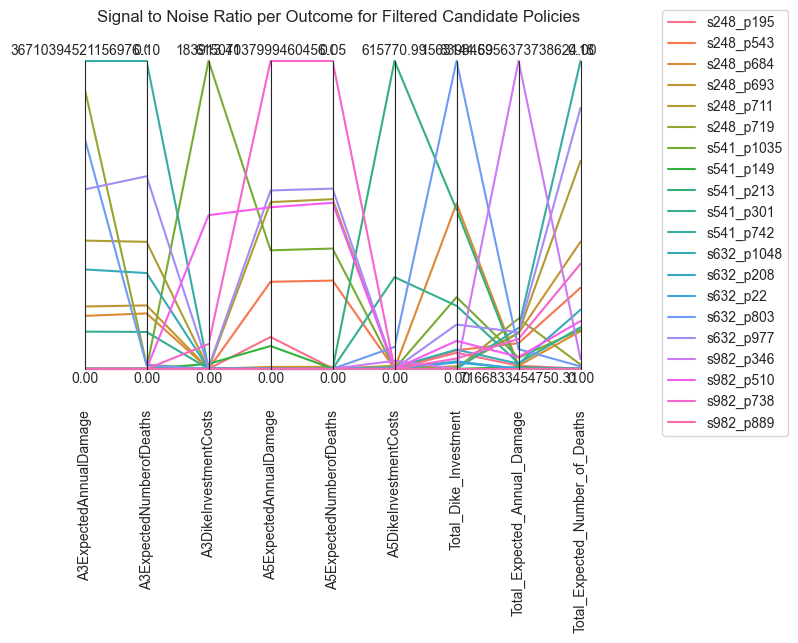

In [66]:
# Plot SNR pairplot
colors = sns.color_palette("husl", all_data.shape[0])
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(all_data.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    
paraxes.legend()
plt.title(f'Signal to Noise Ratio per Outcome for Filtered Candidate Policies', loc='right')
plt.savefig('img/snr__filtered_pairplot.png')

# Export the plotted data to CSV
all_data.to_csv('./output/filtered_policies.csv')

#### 3.3 Max Regret plotting

In [53]:
# Prepare new Max Regret data
all_regrets = {}
max_regret = {}

for outcome in model.outcomes:
    data = pd.DataFrame({outcome.name: outcomes[outcome.name], 
                         "policy":experiments['policy'],
                         "scenario":experiments['scenario']})
    
    data = data[data['policy'].isin(remaining_policies)]
    data = data.pivot(index='scenario', columns='policy')
    data.columns = data.columns.get_level_values(1)

    outcome_regret = (data.max(axis=1).values[:, np.newaxis] - data).abs()
    
    all_regrets[outcome.name] = outcome_regret
    max_regret[outcome.name] = outcome_regret.max()

max_regret = pd.DataFrame(max_regret)
data = max_regret
data = data.sort_index()

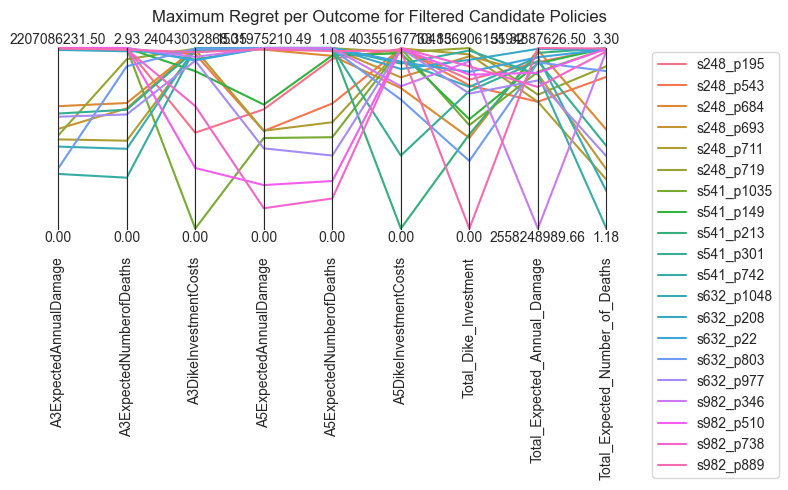

In [55]:
# Plot Max Regret pairplot
limits = parcoords.get_limits(data)
limits.loc[0, outcomes_of_interest] = 0

paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(data.iterrows()):
    colors = sns.color_palette("husl", data.shape[0])
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    
paraxes.legend()
plt.title(f'Maximum Regret per Outcome for Filtered Candidate Policies', loc='right')
plt.savefig('img/regret__filtered_pairplot.png')

Considering the two last plots we can make the final selection of policies.
#### 3.4 Final selection

We choose one policies for each scenarios:
in scenario 248: 195 is selected 
in scenario 982: 346 is selected
in scenario 632: 208 is selected
in scenario 541: 149 is selected

In [74]:
# Select final policies
final_policies = ['s248_p195', 's982_p346', 's632_p208', 's541_p149']

In [68]:
# Filter the selected policies
all_data = all_data.loc[final_policies]
remaining_levers = remaining_levers.loc[final_policies]
remaining_policies = all_data.reset_index()
remaining_policies = remaining_policies.iloc[:,0]
remaining_policies = remaining_policies.tolist()

In [75]:
# Show remaining levers
remaining_levers

,A.1_DikeIncrease 0,A.1_DikeIncrease 1,A.1_DikeIncrease 2,A.2_DikeIncrease 0,A.2_DikeIncrease 1,A.2_DikeIncrease 2,A.3_DikeIncrease 0,A.3_DikeIncrease 1,A.3_DikeIncrease 2,A.4_DikeIncrease 0,A.4_DikeIncrease 1,A.4_DikeIncrease 2,A.5_DikeIncrease 0,A.5_DikeIncrease 1,EWS_DaysToThreat
policy,,,,,,,,,,,,,,,
s248_p195,5.0,5.0,3.0,4.0,10.0,1.0,10.0,3.0,10.0,1.0,1.0,3.0,1.0,4.0,3.0
s982_p346,NaN,1.0,NaN,2.0,1.0,2.0,9.0,1.0,3.0,7.0,6.0,NaN,10.0,9.0,3.0
s632_p208,1.0,7.0,5.0,6.0,1.0,2.0,5.0,4.0,2.0,6.0,1.0,6.0,10.0,4.0,NaN
s541_p149,1.0,6.0,4.0,9.0,6.0,9.0,8.0,5.0,6.0,3.0,7.0,10.0,1.0,7.0,4.0


What remains is to produce a pairplots of mean outcomes for the selected policies.

In [70]:
# Calculate mean outcome and put into a df
mean_scores = {}
for policy in final_policies:
    scores = {}

    logical = experiments['policy']==policy

    for outcome in model.outcomes:
        value  = outcomes[outcome.name][logical]
        mean = np.mean(value)
        scores[outcome.name] = mean
    mean_scores[policy] = scores
mean_scores_df = pd.DataFrame.from_dict(mean_scores).T

In [76]:
# Show mean scores dataframe
mean_scores_df

,A3ExpectedAnnualDamage,A3ExpectedNumberofDeaths,A3DikeInvestmentCosts,A5ExpectedAnnualDamage,A5ExpectedNumberofDeaths,A5DikeInvestmentCosts,Total_Dike_Investment,Total_Expected_Annual_Damage,Total_Expected_Number_of_Deaths
s248_p195,0.000000e+00,0.000000,1.133693e+10,5.570019e+07,0.006220,2.031856e+08,2.139646e+10,7.482996e+07,0.007459
s982_p346,0.000000e+00,0.000000,1.244580e+09,0.000000e+00,0.000000,8.538151e+09,1.092154e+10,7.989492e+08,0.066332
s632_p208,1.357603e+06,0.002642,5.899750e+08,0.000000e+00,0.000000,4.683455e+09,9.967628e+09,2.856406e+06,0.004019
s541_p149,6.247880e+04,0.000017,3.135660e+09,5.498362e+07,0.006105,1.163150e+09,4.422356e+10,5.771299e+07,0.006282


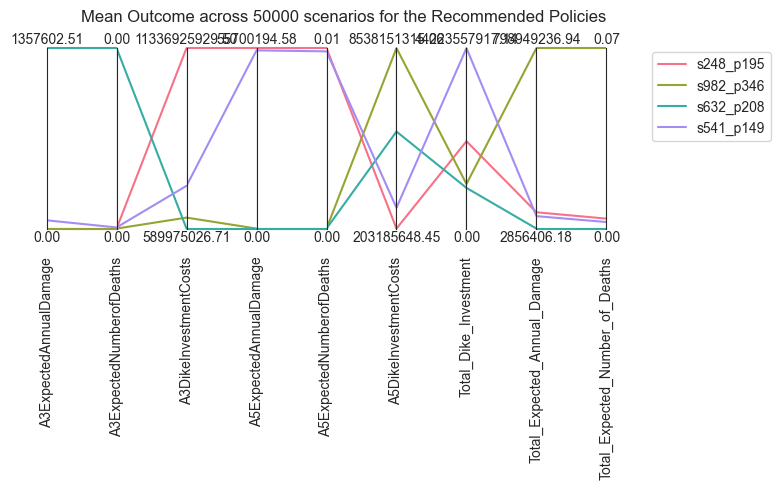

In [72]:
# Plot mean outcomes per 4 selected policies
limits = parcoords.get_limits(mean_scores_df)
limits.loc[0, outcomes_of_interest]  = 0

for outcome in outcomes_of_interest:
    
    limits.loc[1, outcome] = mean_scores_df[outcome].max()

colors = sns.color_palette("husl", mean_scores_df.shape[0])
paraxes = parcoords.ParallelAxes(limits, fontsize=10)

for i, (index, row) in enumerate(mean_scores_df.iterrows()):
    paraxes.plot(row.to_frame().T, label=str(index), color=colors[i])
    
paraxes.legend()
plt.title(f'Mean Outcome across 50000 scenarios for the Recommended Policies', loc='right')
plt.savefig('img/mean__final4_pairplot.png')

Based on the above pairplot, we can see clearly the trade-off between investment costs and flood impacts (damages and deaths). There is no policy that satisfies all of our criteria. 

### 3.5 Saving policies to a file

In [73]:
# This is left commented out due to the seeding/versioning issue between the 
# Directed Search notebook and the run_experiments.py run with mode=robustness.
# `policies__final_set.csv` was constructed manually from previous saved copies
# of the policy list.

policies_df = pd.read_csv('./output/policies__constraints_filtered__diverse_set_50.csv',
                        index_col='Policy Name')
final_policies_df = policies_df.loc[final_policies]
final_policies_df.to_csv('./output/policies__final_set.csv')